## Problem Statement
I read a short article from a financial analysis firm that stated that US light truck sales were postively correleated with economic growth in the US and that growth in US light truck sales could be seen as a predicition of an improving US economy going forward.  The hypothesis was that samll businesses use light trucks to move incoming and outgoing goods for their businesses and that purchases of more light trucks indicates that small businesses are doing well.  Improving small business performance typically leads large business performance as an economy improves so increase in purchases of light trucks might predict an improving economy.  Data offerred was sales data for Ford F-150 trucks for the most recent 24 months which showed a strong general increase which the analyst claimed bode good news for the economy.

I want to test this hypothesis against data for US light truck sales (dollar value of shipments) versus US GDP (dollar value of net output) for the US economy.

A scondary goal for this project is to learn how to do time series analysis with Python and how to predict future values for a time series, ideally based on improved predictability from correlation with another time series.

### Data
The monthly GDP data, February 1992 - August 2017 for theis notebook was obtained from [Y Charts](http://ycharts.com) as a comma delimeted .csv file.  The data describes the monthly US gross domestic product seasonally adjusted and annualized in trillions of US dollars. More information on the data source can be found [here](https://ycharts.com/indicators/sources/macroeconomic_advisers).

The monthly light truck sales data was obtained from the US Census Bureau from their Business and Industry program that collects data about US businesses and governments as part of their Economic Statistical Programs [see](https://www.census.gov/econ/progoverview.html).  The specific data was downloaded in comma dlimited format from the US Census Bureau Time Series interface [see](https://www.census.gov/econ/currentdata/dbsearch?program=M3&startYear=1992&endYear=2017&categories=MTM&dataType=VS&geoLevel=US&adjusted=1&notAdjusted=0&errorData=0) and added as an additional column to the GDP data file to create the input file for this notebook, "US GDP + Light Truck Sales Monthly 1992 - 2017.csv".

Units for  US Light Truck Sales are millions of US dollars and the units for US GDP are trillions of US dollars.

### Analysis Approach
1. Load data and convert GDP data "gdp" and Light Truck Sales data "truck_sales" into individual time series.
2. Check for stationarity and stationize it, if needed, to remove trend and seasonality effects
3. Evaluate correlation between Light Truck Sales as the independent variable and GDP as the dependent variable
4. Forecast GDP based on linear regression with Light Truck Sales, or if correlation is not signficant, with autocorrelation from GDP data.

In [1]:
# load libraries
import pandas as pd
import numpy as np
from pandas import DataFrame
from io import StringIO
from datetime import date
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/Users/ericwk/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read .csv file into pandas dataframe and inspect it
df_data = pd.read_csv("Data/US GDP + Light Truck Sales Monthly 1992 - 2017.csv")
df_data.head()

,period,gdp,truck_sales
0,2/29/1992 0:00,6376.54293,3931
1,3/31/1992 0:00,6436.58603,4227
2,4/30/1992 0:00,6464.83552,4278
3,5/31/1992 0:00,6450.00784,4564
4,6/30/1992 0:00,6562.05364,4373


In [3]:
df_data.shape

(307, 3)

In [4]:
# convert GDP data to time series with monthly frequency and inspect it
df_data["Date"] = pd.to_datetime(df_data['period'])
indexed_df = df_data.set_index("Date")
ts_gdp = indexed_df["gdp"]
ts_gdp.head()

Date
1992-02-29    6376.54293
1992-03-31    6436.58603
1992-04-30    6464.83552
1992-05-31    6450.00784
1992-06-30    6562.05364
Name: gdp, dtype: float64

In [5]:
ts_gdp = ts_gdp.dropna()

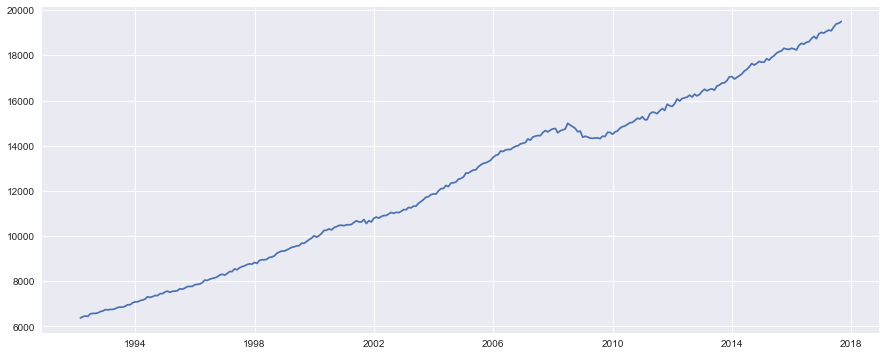

In [6]:
# visualize the data
plt.plot(ts_gdp)

In [7]:
# convert Truck_Sales data to time series with monthly frequency and inspect it
df_data["Date"] = pd.to_datetime(df_data['period'])
indexed_df = df_data.set_index("Date")
ts_truck_sales = indexed_df["truck_sales"]
ts_truck_sales.head()

Date
1992-02-29    3931
1992-03-31    4227
1992-04-30    4278
1992-05-31    4564
1992-06-30    4373
Name: truck_sales, dtype: int64

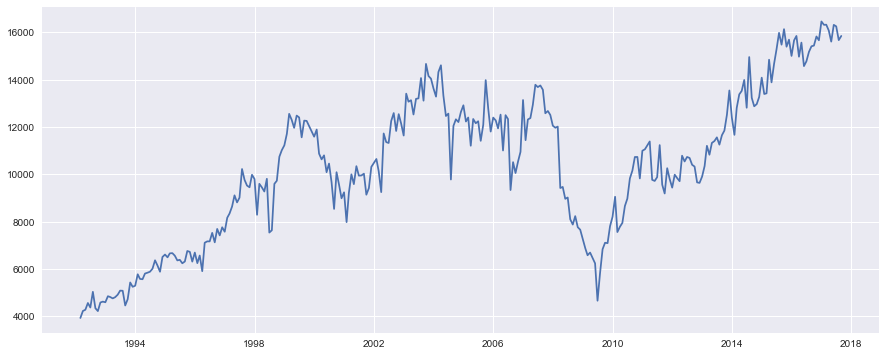

In [8]:
# visualize the data
plt.plot(ts_truck_sales)

### Check for Stationarity
When running a linear regression, observations are expected to be independent of each other.  Observations are time dependent in a time series.  In order to use regression techniques on time dependent variables, the data must be stationary.  The techniques that apply to independent random variables also apply to stationary random variables.

There are two ways to check the stationarity of a time series:
1. Plot the moving variance and observe if it remains constant over time.
2. Use the Dickey-Fuller test, a statistical test with the null hypothesis that the time series is non-stationary.  If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.

In [9]:
# create a function that calculates the movingaverage and standard deviation, plots the results
# and applies the Dickey-Fuller test
def test_stationarity(timeseries):
    # determine rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=13,center=False).std()
    
    # plot rolling statistics
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Standard Deviation")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    # perform Dickey_Fuller Test
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "# Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

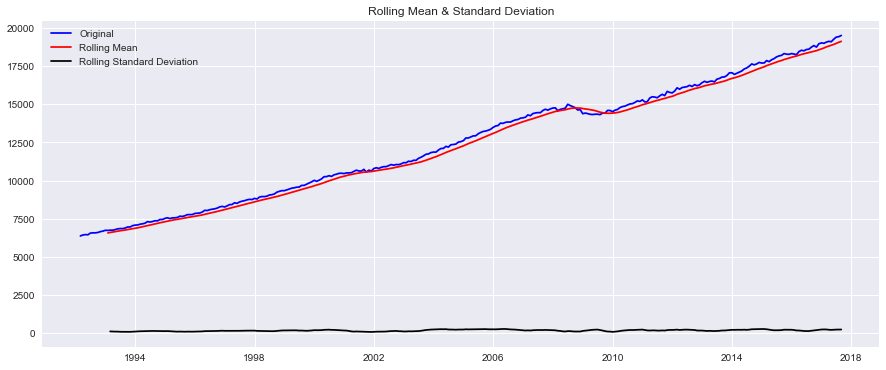

Results of Dickey-Fuller Test:
Test Statistic                   0.583796
p-value                          0.987209
# Lags Used                     15.000000
Number of Observations Used    291.000000
Critical Value (1%)             -3.453023
Critical Value (5%)             -2.871524
Critical Value (10%)            -2.572090
dtype: float64


In [10]:
# test stationarity of GDP data
test_stationarity(ts_gdp)

The test statistic (0.583796) is more than the 5% critical value (-2.871524) and the p-value (0.987209) larger than 0.05 indicates the moving average is not constant over time, so the null hypothesis of the Dickey-Fuller test cannot be rejected.  This shows that the time series is not stationary.

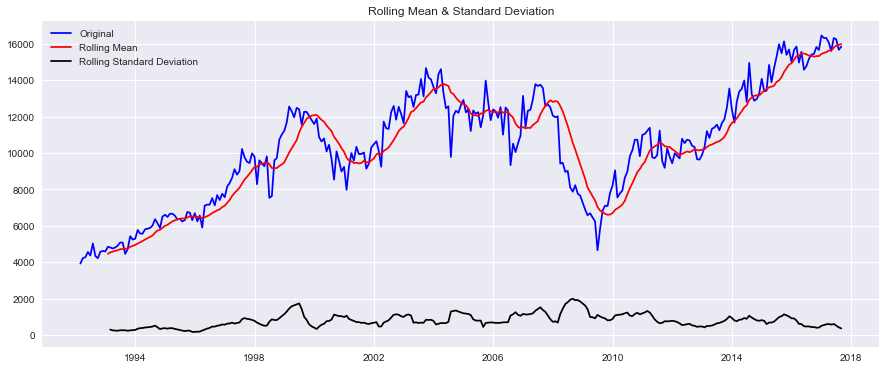

Results of Dickey-Fuller Test:
Test Statistic                  -1.586978
p-value                          0.490132
# Lags Used                     12.000000
Number of Observations Used    294.000000
Critical Value (1%)             -3.452790
Critical Value (5%)             -2.871422
Critical Value (10%)            -2.572035
dtype: float64


In [11]:
# test stationarity of light truck sales data
test_stationarity(ts_truck_sales)

The test statistic (-1.586978) is more than the 5% critical value (-2.871422) and the p-value (0.490132) larger than 0.05 indicates the moving average is not constant over time, so the null hypothesis of the Dickey-Fuller test cannot be rejected.  This shows that the time series is not stationary.

### Stationize the Time Series
The time series can be stationized by calculating the trend and/or seasonality and removing these factors from the model.  Different [transformations](http://people.duke.edu/~rnau/whatuse.htm) can be used for this.

#### Apply Nonlinear Log Transformation

In [12]:
# Apply nonlinear log transformation to GDP data
ts_log_gdp = np.log(ts_gdp)

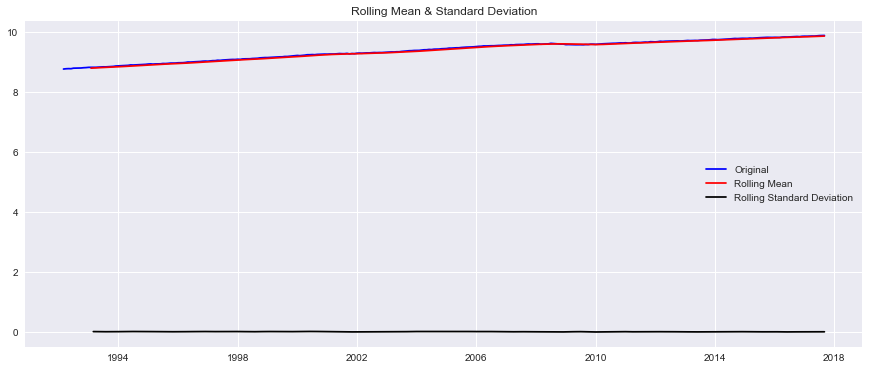

Results of Dickey-Fuller Test:
Test Statistic                  -1.620824
p-value                          0.472297
# Lags Used                     11.000000
Number of Observations Used    295.000000
Critical Value (1%)             -3.452713
Critical Value (5%)             -2.871388
Critical Value (10%)            -2.572017
dtype: float64


In [13]:
# Test for stationarity
test_stationarity(ts_log_gdp)

Again, the test statistic (-1.620824) is larger than the 5% critical value(-2.871388) and the p-value(0.472297) is greater than 0.05 so this transformation did not stationize the data.

In [14]:
# Apply nonlinear log transformation to Light Truck Sales data
ts_log_truck_sales = np.log(ts_truck_sales)

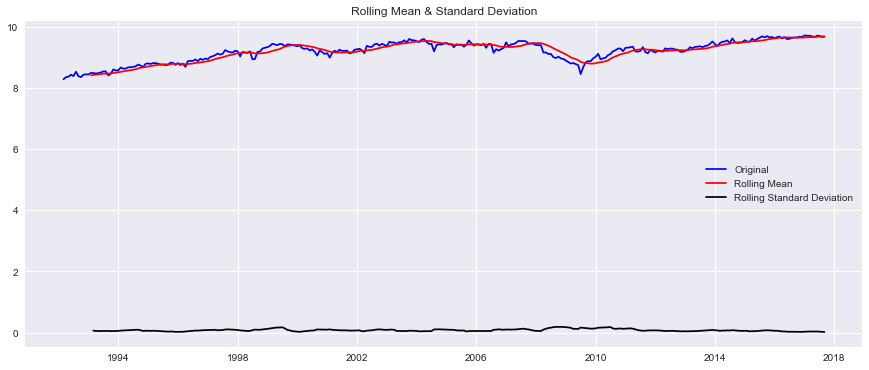

Results of Dickey-Fuller Test:
Test Statistic                  -2.159491
p-value                          0.221275
# Lags Used                      2.000000
Number of Observations Used    304.000000
Critical Value (1%)             -3.452045
Critical Value (5%)             -2.871095
Critical Value (10%)            -2.571861
dtype: float64


In [15]:
# Test for stationarity
test_stationarity(ts_log_truck_sales)

Again, the test statistic (-2.159491) is larger than the 5% critical value(-2.871095) and the p-value(0.221275) is greater than 0.05 so this transformation did not stationize the data.

### Remove Trend and Seasonality

#### Decomposition
The time series can potentially be stationized by decomposing it to remove trend and seasonality, and then model the residuals.

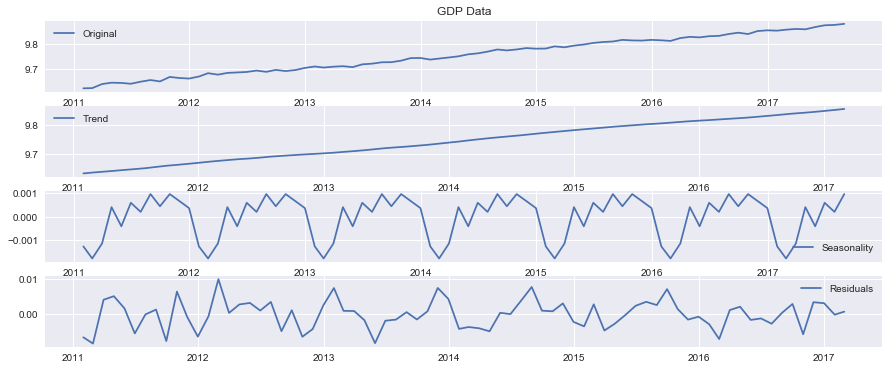

In [16]:
# apply statsmodels seasonal_decompose method to the log transformed GDP data series
decomposition = seasonal_decompose(ts_log_gdp)

# assign trend, seasonal and residual components to variables
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot original data, trend component, seasonal component and residual component
plt.subplot(411)
plt.plot(ts_log_gdp[-80:], label = "Original")
plt.title("GDP Data")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend[-80:], label = "Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal[-80:], label = "Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual[-80:], label = "Residuals")
plt.legend(loc="best")

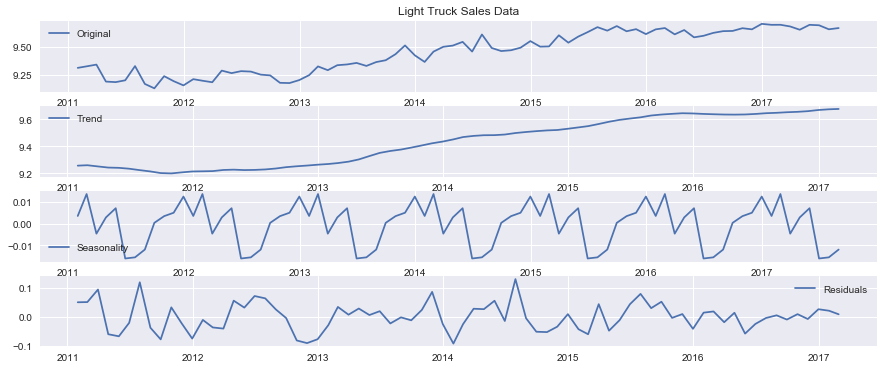

In [17]:
# apply statsmodels seasonal_decompose method to the log transformed Light Truck Sales data series
decomposition = seasonal_decompose(ts_log_truck_sales)

# assign trend, seasonal and residual components to variables
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# plot original data, trend component, seasonal component and residual component
plt.subplot(411)
plt.plot(ts_log_truck_sales[-80:], label = "Original")
plt.legend(loc="best")
plt.title("Light Truck Sales Data")
plt.subplot(412)
plt.plot(trend[-80:], label = "Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal[-80:], label = "Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual[-80:], label = "Residuals")
plt.legend(loc="best")

The trend and seasonality components extracted from the data series after decomposition are not consistent and cannot be scaled back to the original values.

#### Differencing
First order differencing computes the difference between consecutive observations in a time series.  This usually improves the stationarity of the time series.

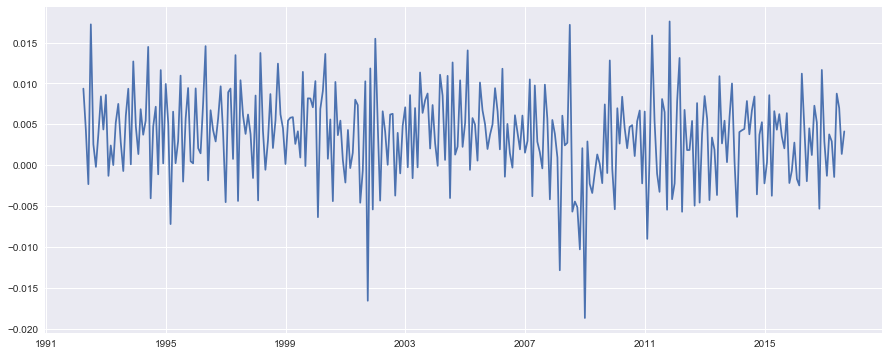

In [18]:
# calculate differences between consecutive values of the log transformed data series (shifted by one period (month))
# for GDP data
ts_log_gdp_diff = ts_log_gdp - ts_log_gdp.shift()
# plot resulting data series
plt.plot(ts_log_gdp_diff)

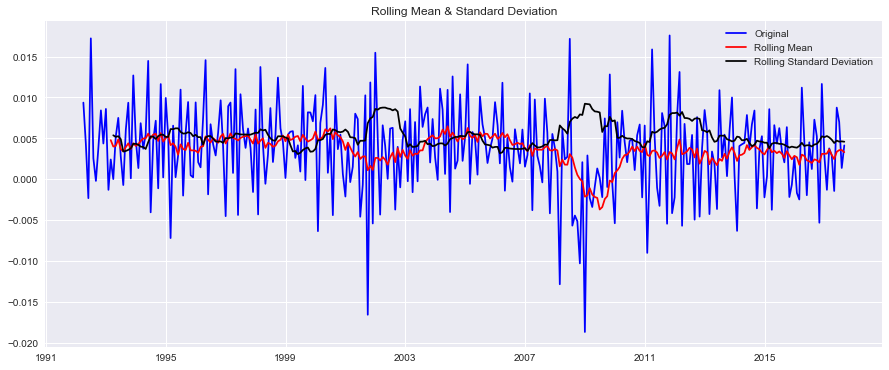

Results of Dickey-Fuller Test:
Test Statistic                  -3.215376
p-value                          0.019112
# Lags Used                     10.000000
Number of Observations Used    295.000000
Critical Value (1%)             -3.452713
Critical Value (5%)             -2.871388
Critical Value (10%)            -2.572017
dtype: float64


In [19]:
# remove missing values
ts_log_gdp_diff.dropna(inplace=True)
# test for stationarity
test_stationarity(ts_log_gdp_diff)

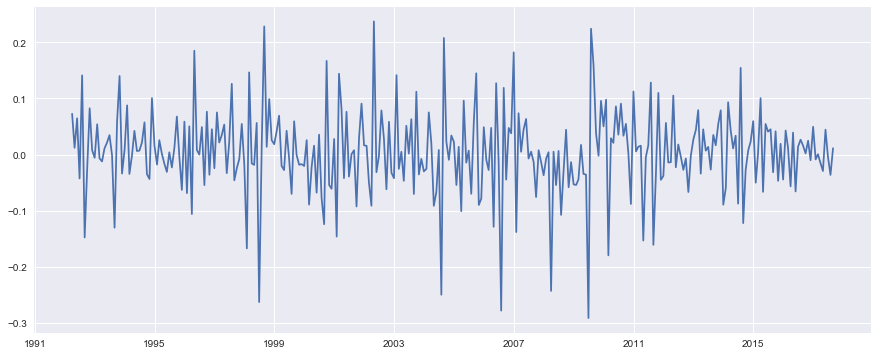

In [20]:
# calculate differences between consecutive values of the log transformed data series (shifted by one period (month))
# for Light Truck Sales data
ts_log_truck_sales_diff = ts_log_truck_sales - ts_log_truck_sales.shift()
# plot resulting data series
plt.plot(ts_log_truck_sales_diff)

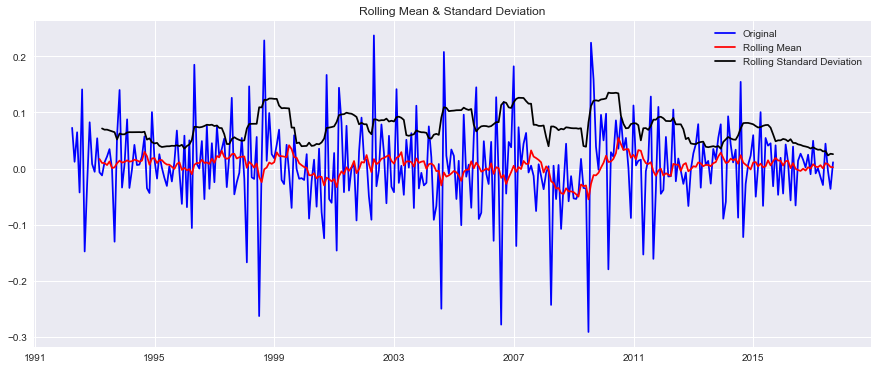

Results of Dickey-Fuller Test:
Test Statistic                -1.637085e+01
p-value                        2.811319e-29
# Lags Used                    1.000000e+00
Number of Observations Used    3.040000e+02
Critical Value (1%)           -3.452045e+00
Critical Value (5%)           -2.871095e+00
Critical Value (10%)          -2.571861e+00
dtype: float64


In [21]:
# remove missing values
ts_log_truck_sales_diff.dropna(inplace=True)
# test for stationarity
test_stationarity(ts_log_truck_sales_diff)

The Dickey-Fuller test shows that the time series is now stationary with a 98% confidence level for GDP and > 99% confidence level for Light Truck Sales.  Statistical models can now be used with this data.

### Evaluate correlation between GDP and Light Truck Sales stationized data

In [22]:
ts_log_gdp_diff.head()

Date
1992-03-31    0.009372
1992-04-30    0.004379
1992-05-31   -0.002296
1992-06-30    0.017222
1992-07-31    0.002576
Name: gdp, dtype: float64

In [23]:
type(ts_log_gdp_diff)

pandas.core.series.Series

In [24]:
ts_log_truck_sales_diff.head()

Date
1992-03-31    0.072599
1992-04-30    0.011993
1992-05-31    0.064714
1992-06-30   -0.042750
1992-07-31    0.141163
Name: truck_sales, dtype: float64

In [25]:
# import Pearson R correlation method for time series
from scipy.stats.stats import pearsonr
# calculate Pearson R correlation coefficient and probability of correlation between time series
pearsonr(ts_log_truck_sales_diff, ts_log_gdp_diff)

(0.092616779075611722, 0.10588291920728291)

This result, correlation coefficient of 0.092... and p-value of 0.105... does not show a strong correlation between these time series.  The hypothesis related time lagged values of Light Truck Sales to GDP so this relationship will be investigated.

In [26]:
# Convert GDP time series to dataframe
stat_gdp = ts_log_gdp_diff.to_frame(name="stat_gdp")
stat_gdp.head()

,stat_gdp
Date,
1992-03-31,0.009372
1992-04-30,0.004379
1992-05-31,-0.002296
1992-06-30,0.017222
1992-07-31,0.002576


In [27]:
type(stat_gdp)

pandas.core.frame.DataFrame

In [28]:
# convert Light Truck Sales time series to dataframe
stat_truck_sales = ts_log_truck_sales_diff.to_frame(name="stat_truck_sales")

In [29]:
type(stat_truck_sales)

pandas.core.frame.DataFrame

In [30]:
# Combine GDP and Light Truck Sales dataframes into a single dataframe with stationized data values for each
stat_data = pd.concat([stat_gdp, stat_truck_sales], axis=1)

In [31]:
stat_data.head()

,stat_gdp,stat_truck_sales
Date,,
1992-03-31,0.009372,0.072599
1992-04-30,0.004379,0.011993
1992-05-31,-0.002296,0.064714
1992-06-30,0.017222,-0.042750
1992-07-31,0.002576,0.141163


In [32]:
# calculate correlation coefficient using pandas .corr() method on the combined dataframe 
# and check against calculation performed above on the separate time series
stat_data.corr()

,stat_gdp,stat_truck_sales
stat_gdp,1.000000,0.092617
stat_truck_sales,0.092617,1.000000


In [33]:
# add columns to the dataframe that include values for Light Truck Sales lagged by 12, 3 1nd 1 months respectively
stat_data["lag_12"] = stat_data["stat_truck_sales"].shift(12)
stat_data["lag_3"] = stat_data["stat_truck_sales"].shift(3)
stat_data["lag_1"] = stat_data["stat_truck_sales"].shift(1)
stat_data.head(20)

,stat_gdp,stat_truck_sales,lag_12,lag_3,lag_1
Date,,,,,
1992-03-31,0.009372,0.072599,NaN,NaN,NaN
1992-04-30,0.004379,0.011993,NaN,NaN,0.072599
1992-05-31,-0.002296,0.064714,NaN,NaN,0.011993
1992-06-30,0.017222,-0.042750,NaN,0.072599,0.064714
1992-07-31,0.002576,0.141163,NaN,0.011993,-0.042750
1992-08-31,-0.000191,-0.148047,NaN,0.064714,0.141163
1992-09-30,0.003826,-0.028256,NaN,-0.042750,-0.148047
1992-10-31,0.008427,0.082481,NaN,0.141163,-0.028256
1992-11-30,0.004378,0.008037,NaN,-0.148047,0.082481


In [34]:
# remove first 12 rows of dataframe for which there is no lagged data for 12 month lag for Light Truck Sales
lagged_stat_data = stat_data[12:]
lagged_stat_data.head()

,stat_gdp,stat_truck_sales,lag_12,lag_3,lag_1
Date,,,,,
1993-03-31,0.000032,-0.012324,0.072599,-0.005859,-0.006827
1993-04-30,0.005206,0.010870,0.011993,0.054010,-0.012324
1993-05-31,0.007510,0.021391,0.064714,-0.006827,0.010870
1993-06-30,0.002818,0.034600,-0.042750,-0.012324,0.021391
1993-07-31,-0.000698,-0.001180,0.141163,0.010870,0.034600


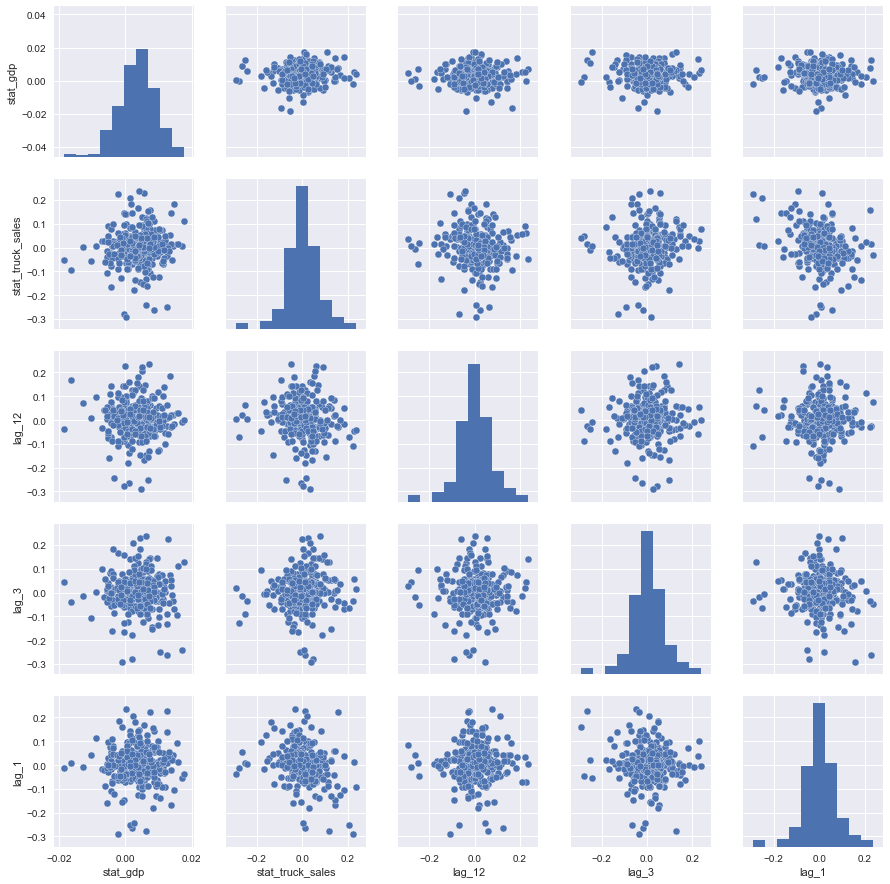

In [35]:
# plot scatter plot of each cross comparison from dataframe
sns.pairplot(lagged_stat_data)

In [36]:
# calculate correlations
lagged_stat_data.corr()

,stat_gdp,stat_truck_sales,lag_12,lag_3,lag_1
stat_gdp,1.000000,0.096738,-0.027597,-0.013660,0.007554
stat_truck_sales,0.096738,1.000000,-0.101387,0.113131,-0.270047
lag_12,-0.027597,-0.101387,1.000000,0.048088,0.009443
lag_3,-0.013660,0.113131,0.048088,1.000000,-0.078572
lag_1,0.007554,-0.270047,0.009443,-0.078572,1.000000


### Conclusion 1
The correlations of lagged Light Truck Sales data are also not strong with GDP.  This will not provide a good basis for forecasting GDP.  An autoregression model will be used for the forecast instead.

## Time Series Forecast
Perform time series analysis using the Autoregressive Integrated Moving Average (ARIMA) technique in Python.  ARIMA modeling, in theory, is the most general class of models for forecasting a time series.

The ARIMA technique seeks to model trends in data over time and then exrrapolate into the future to obtain forecasts.

### Find optimal parameters and build an ARIMA model

Optimal values for three parameters (p,d,q) are required for the ARIMA model
* The number of autoregressive (AR) terms (p):  AR terms are just lags of the dependent variable, GDP, in this case.  So, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).
* The number of moving average (MA) terms(q):  MA terms are lagged forecast errors in the prediction equation.  For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at the ith instant and the actual value.
* The number of differences (d):  These are the number of non-seasonal differences.  In this case, d=1, as we are modeling the first order differenced time series.

There are two ways to determine the AR and MA terms:
* Use the arma_order_select_ic function in Python [see](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.arma_order_select_ic.html).
* Use plots of the autocorrelation function (ACF) and partial autocorrelation function (PACF) [see](http://people.duke.edu/~rnau/411arim3.htm)

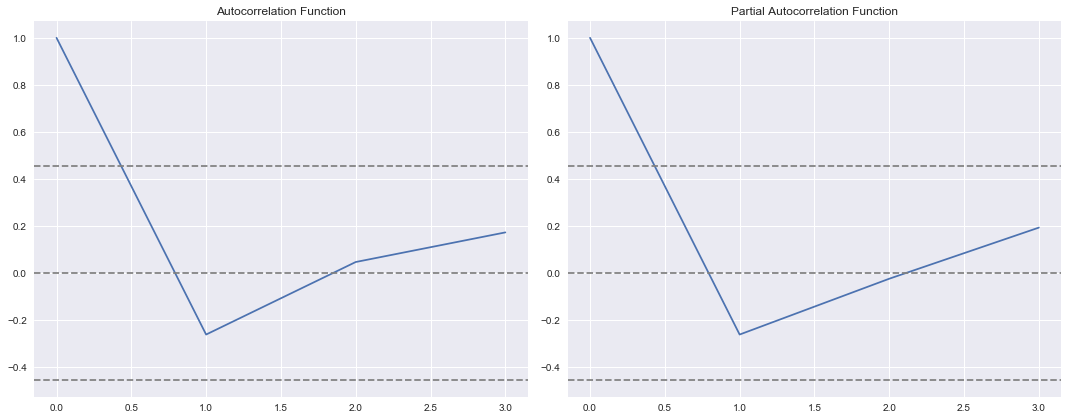

In [37]:
# generate ACF and PACF data series
lag_acf = acf(ts_log_gdp_diff, nlags=3)
lag_pacf = pacf(ts_log_gdp_diff, nlags=3, method="ols")

# plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-7.96/np.sqrt(len(ts_log_gdp_diff)), linestyle="--", color="gray")
plt.axhline(y=7.96/np.sqrt(len(ts_log_gdp_diff)), linestyle="--", color="gray")
plt.title("Autocorrelation Function")

#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-7.96/np.sqrt(len(ts_log_gdp_diff)), linestyle="--", color="gray")
plt.axhline(y=7.96/np.sqrt(len(ts_log_gdp_diff)), linestyle="--", color="gray")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

The "p" and "q" vales can be determined as follows:
* p: The lag value where PACF cuts off (drops to 0) for the first time (p=1)
* q: The lag value where the ACF chart crosses the upper confidence interval for the first time (q=1)

This gives the optimal ARIMA (p,d,q) parameters as (1,1,1)

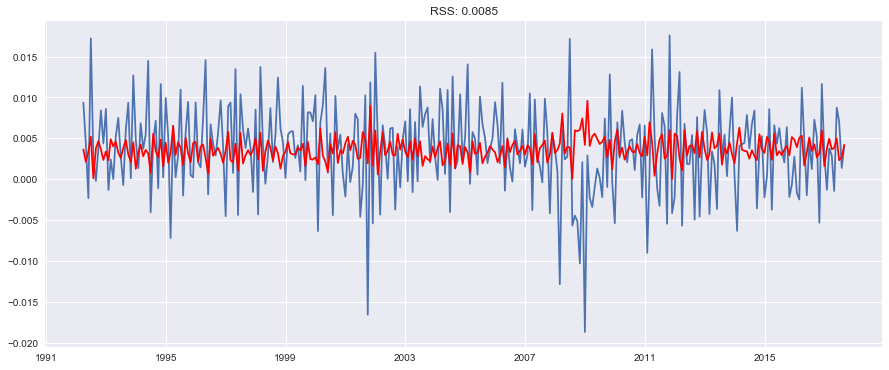

In [38]:
# plot the ARIMA model using the (p,d,q) parameters of (1,1,1)
model = ARIMA (ts_log_gdp, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_gdp_diff)
plt.plot(results_ARIMA.fittedvalues, color="red")
plt.title("RSS: %.4f"% sum((results_ARIMA.fittedvalues-ts_log_gdp_diff)**2))

How well the model fits the underlying data can be measured in two ways:
* Residual sum of squares (RSS) can be used to measure whether the results of the model fit the underlying data.  Small RSS indicates a good fit of the model to the data.
* Perfrom residual analysis by plotting the residual error values as a density plot to determine if it centers around a mean of 0 and shows most values in the range of 1 to -1.

                             ARIMA Model Results                              
Dep. Variable:                  D.gdp   No. Observations:                  306
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1171.127
Method:                       css-mle   S.D. of innovations              0.005
Date:                Mon, 06 Nov 2017   AIC                          -2334.254
Time:                        16:36:48   BIC                          -2319.360
Sample:                    03-31-1992   HQIC                         -2328.297
                         - 08-31-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0036      0.000     15.460      0.000       0.003       0.004
ar.L1.D.gdp    -0.2270      0.141     -1.612      0.108      -0.503       0.049
ma.L1.D.gdp    -0.0389      0.138     -0.282    

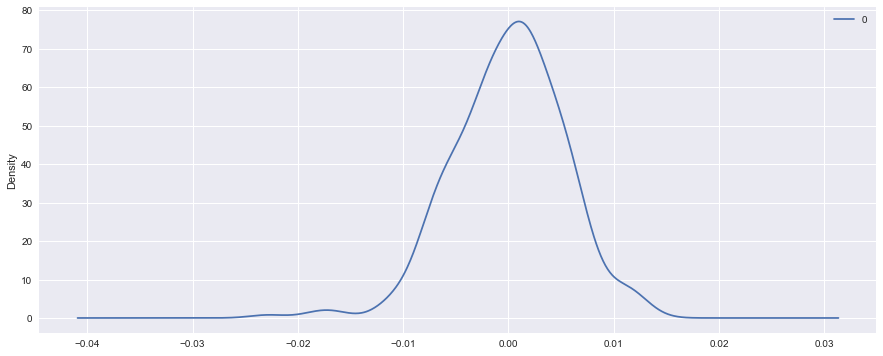

In [39]:
# show ARIMA results summary
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind="kde")
print(residuals.describe())

Residual analysis shows that the model fits well with the underlying data.

### Scale Predictions
The model predictions can be scaled back to the original scale by removing the first order differencing and taking the exponent to remove the log transformation.

In [40]:
# create data Series with ARIMA predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# display first few rows of series
print(predictions_ARIMA_diff.head())

Date
1992-03-31    0.003649
1992-04-30    0.002143
1992-05-31    0.003396
1992-06-30    0.005220
1992-07-31    0.000101
dtype: float64


In [41]:
# remove differencing using cumulative summation on log transformed predictions
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# create data Series of log transformed ARIMA predictions initiated from the first original log transformed value
predictions_ARIMA_log = pd.Series(ts_log_gdp.iloc[0], index=ts_log_gdp.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

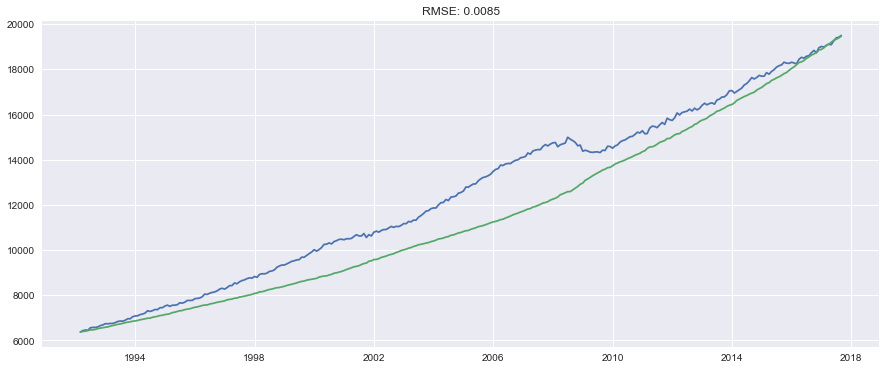

In [42]:
# remove log transformation by taking the exponent
predictions_ARIMA = np.exp(predictions_ARIMA_log)
# plot original data
plt.plot(ts_gdp)
# plot predicted values
plt.plot(predictions_ARIMA)
plt.title("RMSE: %.4f"% sum((results_ARIMA.fittedvalues-ts_log_gdp_diff)**2))

### Perform and visualize time series forecasting
The ARIMA model was used above to create an in-sample forecast of US GDP from January 1992 to August 2017.  The model was trained on the entire time series data.  Now the data will be split into training and testing data sets and the training data set will be used to train the ARIMA model to be used for an out-of-sample forecast.  The statsmodels.tsa.arima_model.ARIMAResults.forecast method will be used to do this [see](http://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html).  

A rolling forecast is required given the dependence on observations during differencing and the AR model. The ARIMA will be recreated after each prediction and observations will be recorded in a list called "history" which is seeded with the training data and to which new predictions are appended in each iteration.

In [43]:
# define train and test data sets
size = int(len(ts_log_gdp) - 15)
train, test = ts_log_gdp[0:size], ts_log_gdp[size:len(ts_log_gdp)]
# create "history" as a list in which to record predictions
history = [x for x in train]
predictions = list()

print("Printing Predicted vs Expected Values...")
print("\n")
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output=model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print("predicted=%f, expected=%f" % (np.exp(yhat), np.exp(obs)))
    
error = mean_squared_error(test, predictions)

print("\n")
print("Printing Mean Squared Error of Predictions...")
print("Test MSE:  %.6f" % error)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=18592.875213, expected=18582.059090
predicted=18646.500510, expected=18605.480410
predicted=18685.106029, expected=18741.599950
predicted=18792.750046, expected=18840.309650
predicted=18901.409885, expected=18740.780020
predicted=18853.066423, expected=18960.461570
predicted=18990.477863, expected=19015.393410
predicted=19088.012007, expected=18991.058870
predicted=19085.643675, expected=19063.034160
predicted=19132.826909, expected=19119.021970
predicted=19192.462680, expected=19091.942280
predicted=19187.196819, expected=19260.017490
predicted=19304.662505, expected=19395.428540
predicted=19448.141567, expected=19422.373320
predicted=19504.387147, expected=19503.067720


Printing Mean Squared Error of Predictions...
Test MSE:  0.000015


The model was validated above by comparing predicted to observed values from the test data set and by calcualting the mean square error.

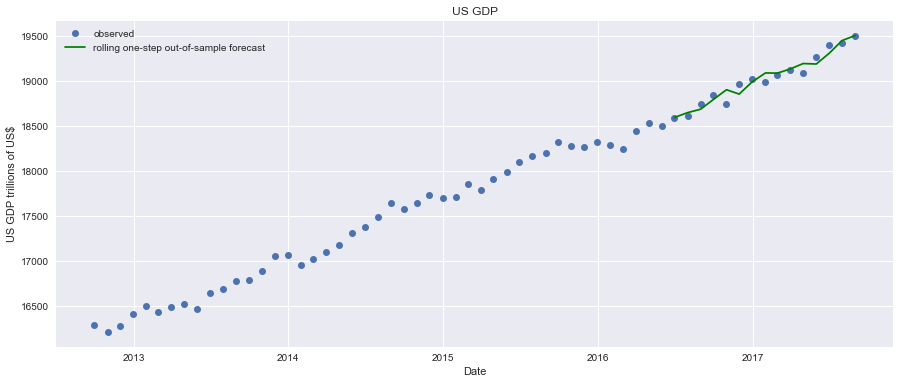

In [44]:
# plot rolling froecast predictions against the observed values
fig, ax = plt.subplots()
ax.set(title="US GDP", xlabel="Date", ylabel="US GDP trillions of US$")
ax.plot(ts_gdp[-60:], "o", label="observed")
ax.plot(np.exp(predictions_series), "g", label="rolling one-step out-of-sample forecast")
legend = ax.legend(loc="upper left")
legend.get_frame().set_facecolor('w')

### Conclusion 2
The ARIMA model provides a fairly good forecast model for GDP in the context of recent relatively smooth growth.

### Next Steps
1. Continue research on timeseries analysis to confirm above conclusions and investigate linear regression models further with better correlated data series.
2. Look for similar but perhaps better supported hypotheses on financial data (perhaps the Dow theory lag correlation for lagged transport sector stock prices versus overall stock market prices) and perform similar analyses to confirm correlations and create forecast models.